# Library

In [645]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()

In [475]:
rng = np.random.default_rng(150)

# Import data & Preprocess

In [476]:
x_read = pd.read_csv("./exercise.csv")
y_read = pd.read_csv("./calories.csv")

x_read = x_read.drop(columns=["User_ID", "Gender"])
y_read = y_read.drop(columns=["User_ID"])

header = x_read.columns

In [459]:
x_read.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,68,190.0,94.0,29.0,105.0,40.8
1,20,166.0,60.0,14.0,94.0,40.3
2,69,179.0,79.0,5.0,88.0,38.7
3,34,179.0,71.0,13.0,100.0,40.5
4,27,154.0,58.0,10.0,81.0,39.8


### Split data

In [432]:
def random_split(x, y):
    assert len(x) == len(y)
    idx_rng = rng.permutation(len(x))

    x_rng = x.iloc[idx_rng].values
    y_rng = y.iloc[idx_rng].values

    train_split = int(0.7 * len(x))
    validate_split = int(0.8 * len(x))

    x_train, x_validate, x_test = np.split(x_rng, [train_split, validate_split])
    y_train, y_validate, y_test = np.split(y_rng, [train_split, validate_split])
    return x_train, x_validate, x_test, y_train, y_validate, y_test


x_train, x_validate, x_test, y_train, y_validate, y_test = random_split(
    x_read, y_read
)

# Basis function

In [553]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.5):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma**2)


def expand(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)


def get_identity_matrix(x):
    return expand(identity_basis_function(x))


def cal_pairwise_dis(x):
    x_cross = x @ x.T
    x_norm = np.repeat(np.diag(x_cross).reshape([1, -1]), x.shape[0], axis=0)
    return np.median(x_norm + x_norm.T - 2 * x_cross)


def get_gaussian_matrix(x, n_centroid=10):
    # Using pairwise distance as sigma
    sigma = cal_pairwise_dis(x)

    x_maxs = np.max(x, axis=0)
    x_mins = np.min(x, axis=0)

    centroids = np.linspace(x_maxs, x_mins, n_centroid, axis=0)

    phi = [
        gaussian_basis_function(x, centroid, sigma) for centroid in centroids
    ]
    phi = np.concatenate(phi, axis=1)

    return expand(phi)

In [ ]:
def normalize(x):
    x_maxs = np.max(x, axis=0)
    x_mins = np.min(x, axis=0)

    return (x - x_mins) / (x_maxs - x_mins)


def calMSE(predict: np.ndarray, actual: np.ndarray):
    return np.mean((predict - actual) ** 2)

# MLR

In [434]:
def MLR(x_train, y_train, x_test, lamda, n_centroid=10):
    x_basisMatrix = get_gaussian_matrix(x_train, n_centroid)
    weight = (
        la.inv(
            x_basisMatrix.T @ x_basisMatrix
            + lamda * np.identity(x_basisMatrix.shape[1])
        )
        @ x_basisMatrix.T
        @ y_train
    )

    y_basisMatrix = get_gaussian_matrix(x_test, n_centroid)
    return y_basisMatrix @ weight

In [647]:
y_MLR = MLR(normalize(x_train), y_train, normalize(x_test), 0.1)
print(calMSE(y_MLR, y_test))

62.18689924314753


# BLR

In [438]:
def posterior(phi, t, alpha, beta, return_inverse=False):
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * phi.T @ phi
    S_N = la.inv(S_N_inv)
    m_N = beta * S_N @ phi.T @ t

    return (m_N, S_N) if not return_inverse else (m_N, S_N, S_N_inv)


def posterior_predictive(phi_test, m_N, S_N, beta):
    y = phi_test @ m_N
    y_var = 1 / beta + phi_test @ S_N @ phi_test.T

    return y, y_var

In [439]:
def fit(phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5):
    """
    Jointly infers the posterior sufficient statistics and optimal values
    for alpha and beta by maximizing the log marginal likelihood.

    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.

    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """

    N, M = phi.shape

    eigenvalues_0 = la.eigvalsh(phi.T.dot(phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N**2)

        beta_inv = 1 / (N - gamma) * np.sum((t - phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(
            beta_prev, beta, rtol=rtol
        ):
            print(f"Convergence after {i + 1} iterations.")
            return alpha, beta, m_N, S_N

    print(f"Stopped after {max_iter} iterations.")
    return alpha, beta, m_N, S_N

In [654]:
phi_train = get_gaussian_matrix(normalize(x_train), 10)
phi_test = get_gaussian_matrix(normalize(x_test), 10)

# m_N, S_N = posterior(phi_train, y_train, alpha, beta)
alpha, beta, m_N, S_N = fit(phi_train, y_train, rtol=10**-5)
y_BLR, y_BLR_var = posterior_predictive(phi_test, m_N, S_N, beta)

calMSE(y_BLR, y_test)

Convergence after 6 iterations.


66.23253795144095

In [441]:
def plot_sample(x_test, y_sample):
    for one in y_sample.T:
        plot_OLS(x_test, one)


def plot_predictive(x_test, y, y_std):
    plot_OLS(x_test, y)
    plt.fill_between(
        x_test[:, 4], y.ravel() - y_std, y.ravel() + y_std, alpha=0.2
    )

# Plot figure

In [733]:
def plot_OLS(ax, x, y, color="black", linestyle="-", label=None):
    dx = np.linspace(x.min(), x.max(), 100)
    m, n = np.polyfit(x, y, 1)
    ax.plot(dx, m * dx + n, c=color, ls=linestyle, label=label)

In [674]:
duration = x_test[:, 3]
duration_unique = np.unique(duration)

## MLR plot

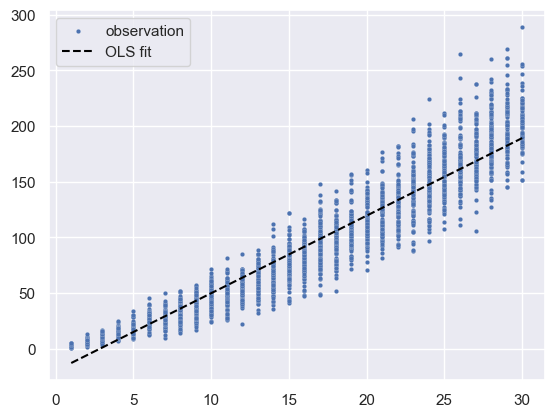

In [744]:
ax = plt.subplot(1, 1, 1)
ax.scatter(
    duration, y_test, label="observation", s=10, edgecolors="w", linewidths=0.1
)
plot_OLS(ax, duration, y_MLR, linestyle="--", label="OLS fit")
ax.legend()
plt.show()

## BLR plot

In [671]:
w_samples = rng.multivariate_normal(m_N.ravel(), S_N, 10, "ignore").T
y_samples = phi_test @ w_samples

### Plot sample line

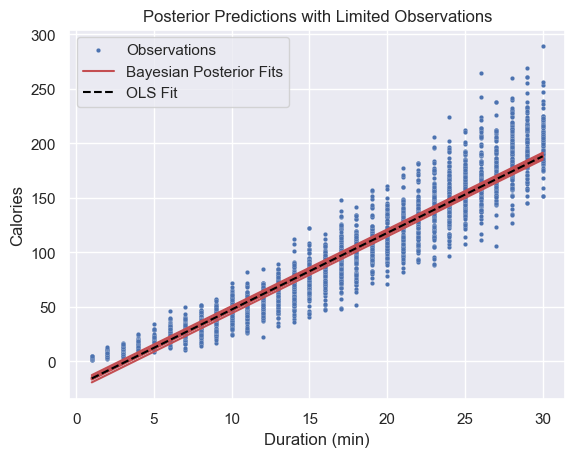

In [739]:
ax = plt.subplot(1, 1, 1)
ax.scatter(
    duration, y_test, s=10, edgecolors="w", linewidths=0.1, label="Observations"
)
for sample in y_samples.T:
    plot_OLS(ax, duration, sample, color="r", label="Bayesian Posterior Fits")
plot_OLS(ax, duration, y_BLR, linestyle="--", label="OLS Fit")

handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []

for handle, label in zip(handles, labels):
    if label not in new_labels:
        new_labels.append(label)
        new_handles.append(handle)

ax.legend(new_handles, new_labels)
ax.set_xlabel("Duration (min)")
ax.set_ylabel("Calories")
ax.set_title("Posterior Predictions with Limited Observations")
plt.show()

### Plot uncertainty

In [754]:
# Means of y of each duration
y_means = [y_BLR[duration == val].mean() for val in duration_unique]
y_means = np.asarray(y_means)

# Standard deviation of y of each duration
y_std = np.sqrt(np.diagonal(y_BLR_var))
y_std_maxs = np.asarray(
    [y_std[duration == val].max() for val in duration_unique]
)

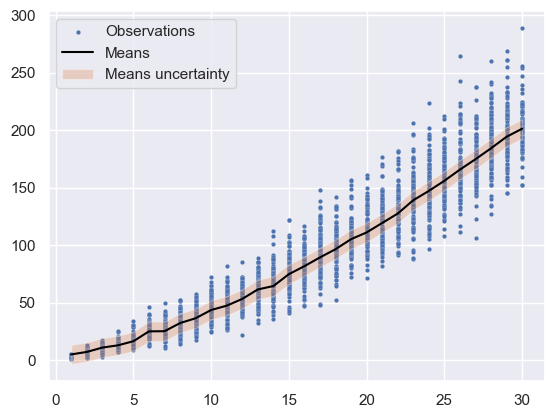

In [757]:
plt.scatter(
    duration, y_test, s=10, edgecolors="w", linewidths=0.1, label="Observations"
)
plt.plot(duration_unique, y_means, c="black", label="Means")
plt.fill_between(
    duration_unique,
    y_means + y_std_maxs,
    y_means - y_std_maxs,
    alpha=0.3,
    label="Means uncertainty",
)
plt.legend()
plt.show()

# Other regression model

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(x_train, y_train.ravel())

y_pred = rf.predict(x_test)

21.471041333333336

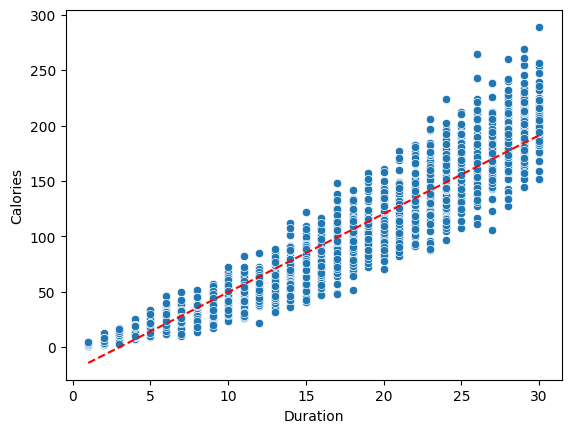

In [ ]:
plot_scatter()
plot_OLS(x_test, y_pred)
calMSE(y_pred.reshape(-1, 1), y_test)